In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [4]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
import optuna

C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from sklearn.feature_selection import SelectFromModel

In [6]:
#model training, base models
train_processed = pd.read_csv('train_processed.csv')
test_processed = pd.read_csv('test_processed.csv')

# define features and target variable
X = train_processed.drop(['SalePrice'], axis=1)
y = train_processed['SalePrice']  # log transformed
X_test = test_processed.copy()
test = pd.read_csv('test.csv')
test_ID = test['Id']  # save test IDs for submission

# split train and validation sets,这里需要分层划分,以避免famd出现问题
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 默认参数基模型训练（使用降维后数据）
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
print(f"RandomForest RMSE (default, reduced): {rf_rmse:.5f}")

# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
print(f"XGBoost RMSE (default, reduced): {xgb_rmse:.5f}")

# LightGBM
lgb = LGBMRegressor(random_state=42,verbose=-1)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_val)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
print(f"LightGBM RMSE (default, reduced): {lgb_rmse:.5f}")

# CatBoost（降维后无需 categorical_features）
# define categorical features for CatBoost
categorical_features = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
                       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
                       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
                       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 
                       'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 
                       'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 
                       'SaleCondition', 'Season']
catboost = CatBoostRegressor(random_state=42, verbose=0, cat_features=categorical_features)
catboost.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)
catboost_pred = catboost.predict(X_val)
catboost_rmse = np.sqrt(mean_squared_error(y_val, catboost_pred))
print(f"CatBoost RMSE (default, reduced): {catboost_rmse:.5f}")

RandomForest RMSE (default, reduced): 0.14926
XGBoost RMSE (default, reduced): 0.14401
LightGBM RMSE (default, reduced): 0.14075
CatBoost RMSE (default, reduced): 0.12099


In [8]:
# # CatBoost
# 

# # train CatBoost
# catboost = CatBoostRegressor(cat_features=categorical_features, random_state=42, verbose=0)
# catboost.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

# # evaluate CatBoost
# catboost_pred = catboost.predict(X_val)
# catboost_rmse = np.sqrt(mean_squared_error(y_val, catboost_pred))
# print(f"CatBoost RMSE: {catboost_rmse:.5f}")

In [9]:
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'random_state': 42
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    return np.sqrt(mean_squared_error(y_val, pred))

rf_study = optuna.create_study(direction='minimize')
rf_study.optimize(rf_objective, n_trials=50)  # RF 调优较慢，减少 trials
rf_best_params = rf_study.best_params
print("Best RandomForest params (Optuna):", rf_best_params)

# 重训练 Random Forest
rf_best = RandomForestRegressor(**rf_best_params, random_state=42)
rf_best.fit(X_train, y_train)
rf_pred = rf_best.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
print(f"Optuna tuned RandomForest RMSE (reduced): {rf_rmse:.5f}")

[I 2025-08-16 18:04:31,312] A new study created in memory with name: no-name-11ed2347-e882-4350-894e-ba054ee7a3a7
[I 2025-08-16 18:04:42,499] Trial 0 finished with value: 0.15558672952262761 and parameters: {'n_estimators': 930, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.15558672952262761.
[I 2025-08-16 18:04:55,419] Trial 1 finished with value: 0.14899987883804275 and parameters: {'n_estimators': 753, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.14899987883804275.
[I 2025-08-16 18:04:57,485] Trial 2 finished with value: 0.1536021944968812 and parameters: {'n_estimators': 151, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.14899987883804275.
[I 2025-08-16 18:05:01,626] Trial 3 finished with value: 0.14930586889998207 and parameters: {'n_estimators': 256, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 wit

Best RandomForest params (Optuna): {'n_estimators': 602, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1}
Optuna tuned RandomForest RMSE (reduced): 0.14611


In [10]:
# 使用 Optuna 调优（每个模型单独定义 objective）
# XGBoost Optuna 调优
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'random_state': 42
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    return np.sqrt(mean_squared_error(y_val, pred))

xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_objective, n_trials=100)
xgb_best_params = xgb_study.best_params
print("Best XGBoost params (Optuna):", xgb_best_params)

# 重训练 XGBoost
xgb_best = XGBRegressor(**xgb_best_params, random_state=42)
xgb_best.fit(X_train, y_train)
xgb_pred = xgb_best.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
print(f"Optuna tuned XGBoost RMSE (reduced): {xgb_rmse:.5f}")

[I 2025-08-16 18:13:52,294] A new study created in memory with name: no-name-4b40b8fd-0eb4-44d9-b2c1-1438c5f633fe
[I 2025-08-16 18:13:52,992] Trial 0 finished with value: 0.13636452503242125 and parameters: {'n_estimators': 309, 'learning_rate': 0.029558864639562754, 'max_depth': 7, 'subsample': 0.9056100835367614, 'colsample_bytree': 0.7224233484789173, 'min_child_weight': 3}. Best is trial 0 with value: 0.13636452503242125.
[I 2025-08-16 18:13:53,414] Trial 1 finished with value: 0.1284862807919541 and parameters: {'n_estimators': 303, 'learning_rate': 0.06547343115065118, 'max_depth': 6, 'subsample': 0.7633831222852644, 'colsample_bytree': 0.9707671637538304, 'min_child_weight': 4}. Best is trial 1 with value: 0.1284862807919541.
[I 2025-08-16 18:13:53,621] Trial 2 finished with value: 0.12616221574379013 and parameters: {'n_estimators': 181, 'learning_rate': 0.037122185514220606, 'max_depth': 5, 'subsample': 0.7121206896464632, 'colsample_bytree': 0.7524577464524967, 'min_child_wei

Best XGBoost params (Optuna): {'n_estimators': 998, 'learning_rate': 0.02169847082294126, 'max_depth': 3, 'subsample': 0.7355745841286393, 'colsample_bytree': 0.7474104234737726, 'min_child_weight': 4}
Optuna tuned XGBoost RMSE (reduced): 0.11968


In [11]:
# LightGBM Optuna 调优
def lgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'random_state': 42
    }
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    return np.sqrt(mean_squared_error(y_val, pred))

lgb_study = optuna.create_study(direction='minimize')
lgb_study.optimize(lgb_objective, n_trials=100)
lgb_best_params = lgb_study.best_params
print("Best LightGBM params (Optuna):", lgb_best_params)

# 重训练 LightGBM
lgb_best = LGBMRegressor(**lgb_best_params, random_state=42,verbose=-1)
lgb_best.fit(X_train, y_train)
lgb_pred = lgb_best.predict(X_val)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
print(f"Optuna tuned LightGBM RMSE (reduced): {lgb_rmse:.5f}")

[I 2025-08-16 18:14:57,596] A new study created in memory with name: no-name-03b3f74b-fc4d-45ca-9f32-7255db54f408
[I 2025-08-16 18:14:57,840] Trial 0 finished with value: 0.13238584853598964 and parameters: {'n_estimators': 751, 'learning_rate': 0.03914522511753722, 'max_depth': 4, 'num_leaves': 49, 'subsample': 0.79464447257784, 'colsample_bytree': 0.9165430105060277}. Best is trial 0 with value: 0.13238584853598964.
[I 2025-08-16 18:14:58,207] Trial 1 finished with value: 0.13440823081540015 and parameters: {'n_estimators': 678, 'learning_rate': 0.07465087325810206, 'max_depth': 7, 'num_leaves': 53, 'subsample': 0.8899631076919292, 'colsample_bytree': 0.8560799742168331}. Best is trial 0 with value: 0.13238584853598964.
[I 2025-08-16 18:14:58,357] Trial 2 finished with value: 0.12910282599405762 and parameters: {'n_estimators': 665, 'learning_rate': 0.07617639327385918, 'max_depth': 3, 'num_leaves': 29, 'subsample': 0.7391171915377228, 'colsample_bytree': 0.920789589103142}. Best is 

Best LightGBM params (Optuna): {'n_estimators': 431, 'learning_rate': 0.0460666144564313, 'max_depth': 3, 'num_leaves': 56, 'subsample': 0.8385746548288031, 'colsample_bytree': 0.7810285300858271}
Optuna tuned LightGBM RMSE (reduced): 0.12535


In [12]:
# CatBoost Optuna 调优
def catboost_objective(trial):
    params = {
        'iterations': 500,  # 初始小值，之后可增大
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 7),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'random_state': 42,
        'verbose': 0
    }
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)
    pred = model.predict(X_val)
    return np.sqrt(mean_squared_error(y_val, pred))

catboost_study = optuna.create_study(direction='minimize')
catboost_study.optimize(catboost_objective, n_trials=100)
catboost_best_params = catboost_study.best_params
catboost_best_params['iterations'] = 5000  # 增大 iterations 以利用最佳参数
print("Best CatBoost params (Optuna):", catboost_best_params)

# 重训练 CatBoost
catboost_best = CatBoostRegressor(**catboost_best_params, random_state=42, verbose=100)
catboost_best.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=200)
catboost_pred = catboost_best.predict(X_val)
catboost_rmse = np.sqrt(mean_squared_error(y_val, catboost_pred))
print(f"Optuna tuned CatBoost RMSE (reduced): {catboost_rmse:.5f}")

[I 2025-08-16 18:15:12,604] A new study created in memory with name: no-name-ac11b9c4-c3ba-47c4-ad95-016e089e348f
[I 2025-08-16 18:15:13,341] Trial 0 finished with value: 0.11845567403372945 and parameters: {'learning_rate': 0.027517514137375063, 'depth': 5, 'l2_leaf_reg': 7, 'bagging_temperature': 0.08450929433902066, 'border_count': 97}. Best is trial 0 with value: 0.11845567403372945.
[I 2025-08-16 18:15:14,040] Trial 1 finished with value: 0.12013783262551601 and parameters: {'learning_rate': 0.04361922971079469, 'depth': 6, 'l2_leaf_reg': 2, 'bagging_temperature': 0.11676014557745207, 'border_count': 95}. Best is trial 0 with value: 0.11845567403372945.
[I 2025-08-16 18:15:15,078] Trial 2 finished with value: 0.12068161344221548 and parameters: {'learning_rate': 0.024911629258892565, 'depth': 7, 'l2_leaf_reg': 7, 'bagging_temperature': 0.45813600660292786, 'border_count': 44}. Best is trial 0 with value: 0.11845567403372945.
[I 2025-08-16 18:15:20,697] Trial 3 finished with value:

Best CatBoost params (Optuna): {'learning_rate': 0.0468596045669833, 'depth': 4, 'l2_leaf_reg': 7, 'bagging_temperature': 0.6968563081145456, 'border_count': 95, 'iterations': 5000}
0:	learn: 0.3827110	test: 0.3866481	best: 0.3866481 (0)	total: 1.53ms	remaining: 7.64s
100:	learn: 0.1216294	test: 0.1378838	best: 0.1378838 (100)	total: 109ms	remaining: 5.3s
200:	learn: 0.1004889	test: 0.1220689	best: 0.1220689 (200)	total: 205ms	remaining: 4.89s
300:	learn: 0.0881742	test: 0.1164695	best: 0.1163400 (297)	total: 295ms	remaining: 4.61s
400:	learn: 0.0805175	test: 0.1146426	best: 0.1146174 (397)	total: 393ms	remaining: 4.5s
500:	learn: 0.0757622	test: 0.1142290	best: 0.1141972 (477)	total: 484ms	remaining: 4.35s
600:	learn: 0.0712827	test: 0.1143671	best: 0.1141972 (477)	total: 573ms	remaining: 4.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.1141971651
bestIteration = 477

Shrink model to first 478 iterations.
Optuna tuned CatBoost RMSE (reduced): 0.11420


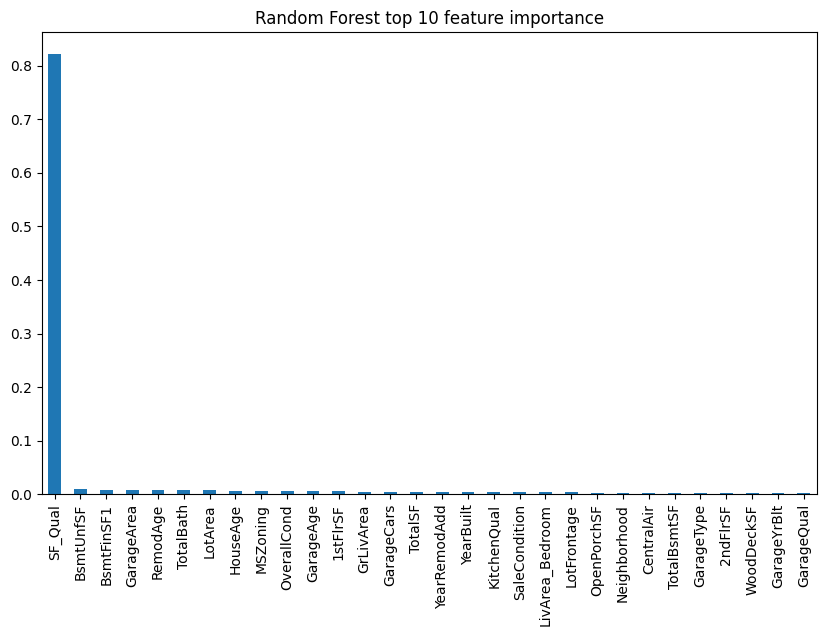

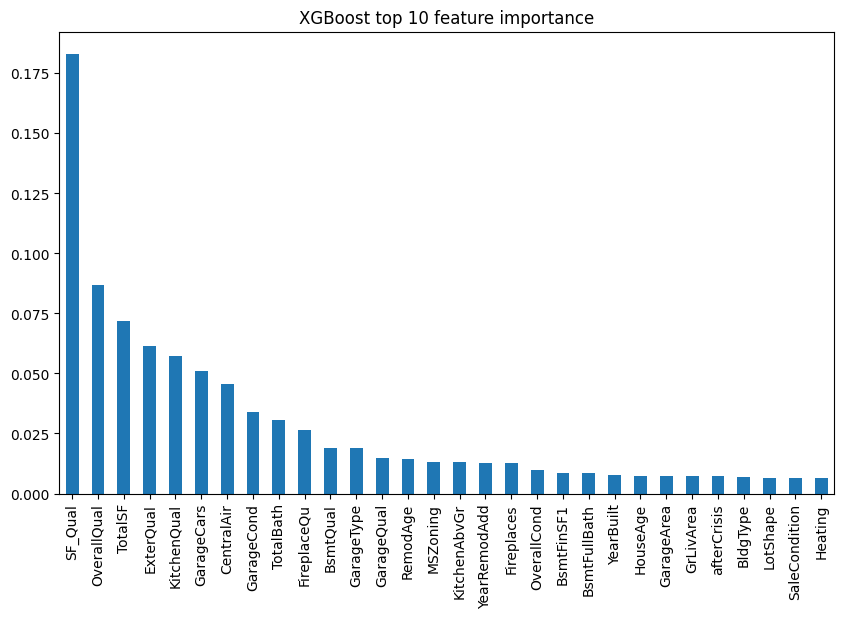

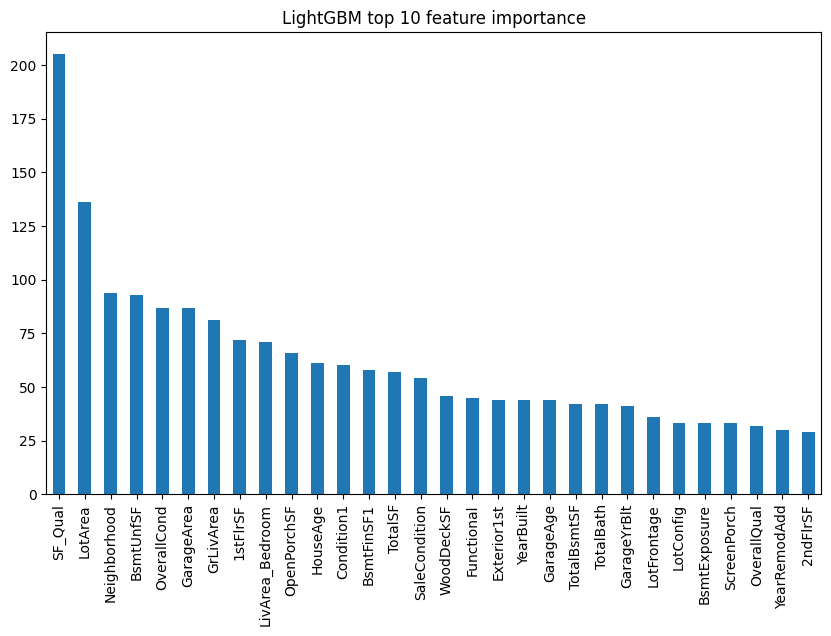

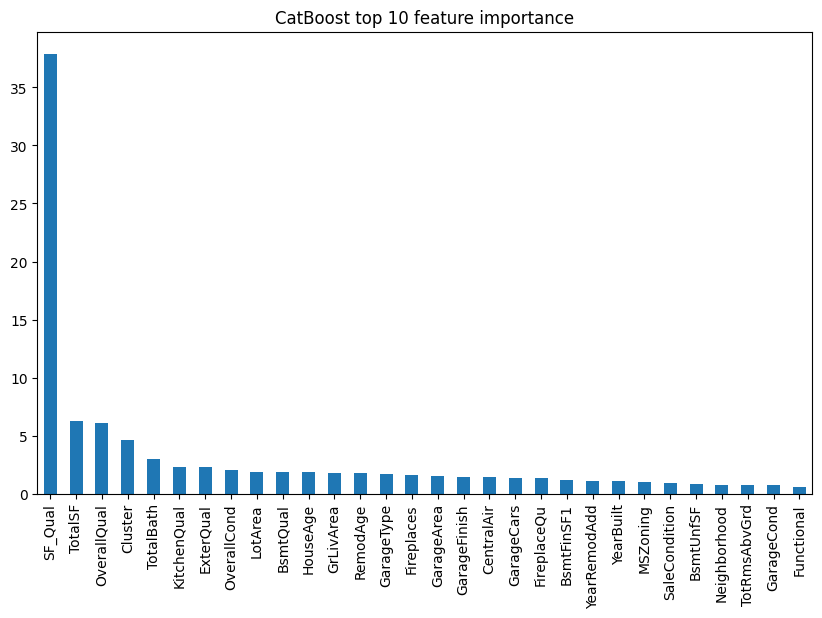

In [13]:
# feature importance visualization
# Random Forest feature importance
rf_importance = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
rf_importance[:30].plot(kind='bar')
plt.title('Random Forest top 10 feature importance')
plt.show()

# XGBoost feature importance
xgb_importance = pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
xgb_importance[:30].plot(kind='bar')
plt.title('XGBoost top 10 feature importance')
plt.show()

# LightGBM feature importance
lgb_importance = pd.Series(lgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
lgb_importance[:30].plot(kind='bar')
plt.title('LightGBM top 10 feature importance')
plt.show()

# CatBoost feature importance
catboost_importance = pd.Series(catboost_best.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
catboost_importance[:30].plot(kind='bar')
plt.title('CatBoost top 10 feature importance')
plt.show()

In [14]:
# Random Forest cross-validation
rf_cv_scores = cross_val_score(rf_best, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"Random Forest cross-validation RMSE: {-rf_cv_scores.mean():.5f} (+/- {rf_cv_scores.std() * 2:.5f})")

# XGBoost cross-validation
xgb_cv_scores = cross_val_score(xgb_best, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"XGBoost cross-validation RMSE: {-xgb_cv_scores.mean():.5f} (+/- {xgb_cv_scores.std() * 2:.5f})")

# LightGBM cross-validation
lgb_cv_scores = cross_val_score(lgb_best, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"LightGBM cross-validation RMSE: {-lgb_cv_scores.mean():.5f} (+/- {lgb_cv_scores.std() * 2:.5f})")

# CatBoost cross-validation
catboost_cv_scores = cross_val_score(catboost_best, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"CatBoost cross-validation RMSE: {-catboost_cv_scores.mean():.5f} (+/- {catboost_cv_scores.std() * 2:.5f})")

Random Forest cross-validation RMSE: 0.13466 (+/- 0.00945)
XGBoost cross-validation RMSE: 0.11522 (+/- 0.01194)
LightGBM cross-validation RMSE: 0.12054 (+/- 0.01163)
0:	learn: 0.3867354	total: 1.24ms	remaining: 6.22s
100:	learn: 0.1246271	total: 96ms	remaining: 4.66s
200:	learn: 0.1032710	total: 183ms	remaining: 4.36s
300:	learn: 0.0923795	total: 269ms	remaining: 4.2s
400:	learn: 0.0842893	total: 361ms	remaining: 4.14s
500:	learn: 0.0776420	total: 447ms	remaining: 4.01s
600:	learn: 0.0726485	total: 532ms	remaining: 3.89s
700:	learn: 0.0685997	total: 616ms	remaining: 3.78s
800:	learn: 0.0651649	total: 701ms	remaining: 3.67s
900:	learn: 0.0618347	total: 787ms	remaining: 3.58s
1000:	learn: 0.0584024	total: 870ms	remaining: 3.48s
1100:	learn: 0.0552719	total: 956ms	remaining: 3.38s
1200:	learn: 0.0525310	total: 1.04s	remaining: 3.3s
1300:	learn: 0.0503202	total: 1.13s	remaining: 3.23s
1400:	learn: 0.0480694	total: 1.23s	remaining: 3.16s
1500:	learn: 0.0459145	total: 1.32s	remaining: 3.09s


In [15]:
# predict on test set
rf_test_pred = rf_best.predict(X_test)
xgb_test_pred = xgb_best.predict(X_test)
lgb_test_pred = lgb_best.predict(X_test)
catboost_test_pred = catboost_best.predict(X_test)

# simple ensemble (average predictions)
final_pred = (catboost_test_pred + rf_test_pred + xgb_test_pred + lgb_test_pred) / 4

# expm1 transformation to reverse log transformation
final_pred = np.expm1(final_pred)

# save submission file
submission = pd.DataFrame({'Id': test_ID, 'SalePrice': final_pred})
submission.to_csv('submission_baseline.csv', index=False)

In [16]:
# define base models for stacking
base_models = [
    ('rf', RandomForestRegressor(**rf_best_params, random_state=42)),
    ('xgb', XGBRegressor(**xgb_best_params, random_state=42)),
    ('lgb', LGBMRegressor(**lgb_best_params, random_state=42, verbose=-1)),
    ('catboost', CatBoostRegressor(**catboost_best_params, random_state=42, verbose=0))
]

# define meta learner
# meta_learner = Ridge()
# first try use normal parameters for LGBMRegressor
meta_learner = LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, 
                             num_leaves=15, random_state=42)
# initia Stacking
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_learner, cv=5)

# train Stacking model
stacking_model.fit(X_train, y_train)

# validate Stacking model
stacking_pred = stacking_model.predict(X_val)
stacking_rmse = np.sqrt(mean_squared_error(y_val, stacking_pred))
print(f"Stacking RMSE: {stacking_rmse:.5f}")

# cross-validation
stacking_cv_scores = cross_val_score(stacking_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"Stacking cross-validation RMSE: {-stacking_cv_scores.mean():.5f} (+/- {stacking_cv_scores.std() * 2:.5f})")

# predict on test set
stacking_test_pred = stacking_model.predict(X_test)
stacking_test_pred = np.expm1(stacking_test_pred)

# save submission file
submission_stacking = pd.DataFrame({'Id': test_ID, 'SalePrice': stacking_test_pred})
submission_stacking.to_csv('submission_stacking.csv', index=False)

C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Stacking RMSE: 0.12109


C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Stacking cross-validation RMSE: 0.11858 (+/- 0.00804)


In [17]:
# second round to pick feature importance

In [25]:
exclude_features = ['TotalSF', 'HouseAge', 'RemodAge', 'TotalBath', 
                    'TotalRooms', 'GarageAge', 'HasPool', 'HasFence', 
                    'HasMisc', 'SF_Qual', 'LivArea_Bedroom', 
                    'Neighborhood_MeanPrice', 'Season', 'Cluster',
                    'beforeCrisis','inCrisis','afterCrisis']
X_train_filtered = X_train.drop(columns=exclude_features)
X_val_filtered = X_val.drop(columns=exclude_features)
X_test_filtered = X_test.drop(columns=exclude_features)
# selector = SelectFromModel(catboost, threshold='mean',prefit=False)
categorical_features_selected = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
                       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
                       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
                       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 
                       'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 
                       'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 
                       'SaleCondition']
selector = SelectFromModel(CatBoostRegressor(random_state=42, verbose=0, cat_features=categorical_features_selected), max_features=20, prefit=False)
selector.fit(X_train_filtered, y_train)
selected_features = X_train_filtered.columns[selector.get_support()].tolist()
print(f"Selected features: ({len(selected_features)}): {selected_features}")

# transform the data
X_train_importanced = selector.transform(X_train_filtered)
X_val_importanced = selector.transform(X_val_filtered)
X_test_importanced = selector.transform(X_test_filtered)
np1 = X_train_importanced
np2 = X_train[exclude_features]
np3 = X_val_importanced
np4 = X_val[exclude_features]
np5 = X_test_importanced
np6 = X_test[exclude_features]
X_train_selected = np.concatenate([np1,np2],axis=1)
X_val_selected = np.concatenate([np3,np4],axis=1)
X_test_selected = np.concatenate([np5,np6],axis=1)

Selected features: (20): ['MSZoning', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageArea']


In [29]:
# 默认参数基模型训练（使用降维后数据）
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_selected, y_train)
rf_pred = rf.predict(X_val_selected)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
print(f"RandomForest RMSE (default, reduced): {rf_rmse:.5f}")

# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_selected, y_train)
xgb_pred = xgb.predict(X_val_selected)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
print(f"XGBoost RMSE (default, reduced): {xgb_rmse:.5f}")

# LightGBM
lgb = LGBMRegressor(random_state=42,verbose=-1)
lgb.fit(X_train_selected, y_train)
lgb_pred = lgb.predict(X_val_selected)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
print(f"LightGBM RMSE (default, reduced): {lgb_rmse:.5f}")

# CatBoost（降维后无需 categorical_features）
# define categorical features for CatBoost
# categorical_features = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
#                        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
#                        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
#                        'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 
#                        'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 
#                        'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 
#                        'SaleCondition', 'Season']
# categorical_features_selected = list(set(categorical_features + selected_features))
catboost = CatBoostRegressor(random_state=42, verbose=0)
catboost.fit(X_train_selected, y_train, eval_set=(X_val_selected, y_val), early_stopping_rounds=50)
catboost_pred = catboost.predict(X_val_selected)
catboost_rmse = np.sqrt(mean_squared_error(y_val, catboost_pred))
print(f"CatBoost RMSE (default, reduced): {catboost_rmse:.5f}")

RandomForest RMSE (default, reduced): 0.14945
XGBoost RMSE (default, reduced): 0.14604


C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM RMSE (default, reduced): 0.14434
CatBoost RMSE (default, reduced): 0.12356


In [30]:
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'random_state': 42
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train_selected, y_train)
    pred = model.predict(X_val_selected)
    return np.sqrt(mean_squared_error(y_val, pred))

rf_selected_study = optuna.create_study(direction='minimize')
rf_selected_study.optimize(rf_objective, n_trials=50)  # RF 调优较慢，减少 trials
rf_selected_best_params = rf_selected_study.best_params
print("Best RandomForest params (Optuna):", rf_selected_best_params)

# 重训练 Random Forest
rf_selected_best = RandomForestRegressor(**rf_selected_best_params, random_state=42)
rf_selected_best.fit(X_train_selected, y_train)
rf_selected_pred = rf_selected_best.predict(X_val_selected)
rf_selected_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
print(f"Optuna tuned RandomForest RMSE (reduced): {rf_rmse:.5f}")

# 使用 Optuna 调优（每个模型单独定义 objective）
# XGBoost Optuna 调优
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'random_state': 42
    }
    model = XGBRegressor(**params)
    model.fit(X_train_selected, y_train)
    pred = model.predict(X_val_selected)
    return np.sqrt(mean_squared_error(y_val, pred))

xgb_selected_study = optuna.create_study(direction='minimize')
xgb_selected_study.optimize(xgb_objective, n_trials=100)
xgb_selected_best_params = xgb_selected_study.best_params
print("Best XGBoost params (Optuna):", xgb_selected_best_params)

# 重训练 XGBoost
xgb_selected_best = XGBRegressor(**xgb_selected_best_params, random_state=42)
xgb_selected_best.fit(X_train_selected, y_train)
xgb_selected_pred = xgb_selected_best.predict(X_val_selected)
xgb_selected_rmse = np.sqrt(mean_squared_error(y_val, xgb_selected_pred))
print(f"Optuna tuned XGBoost RMSE (reduced): {xgb_selected_rmse:.5f}")

# LightGBM Optuna 调优
def lgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'random_state': 42
    }
    model = LGBMRegressor(**params)
    model.fit(X_train_selected, y_train)
    pred = model.predict(X_val_selected)
    return np.sqrt(mean_squared_error(y_val, pred))

lgb_selected_study = optuna.create_study(direction='minimize')
lgb_selected_study.optimize(lgb_objective, n_trials=100)
lgb_selected_best_params = lgb_selected_study.best_params
print("Best LightGBM params (Optuna):", lgb_selected_best_params)

# 重训练 LightGBM
lgb_selected_best = LGBMRegressor(**lgb_selected_best_params, random_state=42,verbose=-1)
lgb_selected_best.fit(X_train_selected, y_train)
lgb_selected_pred = lgb_selected_best.predict(X_val_selected)
lgb_selected_rmse = np.sqrt(mean_squared_error(y_val, lgb_selected_pred))
print(f"Optuna tuned LightGBM RMSE (reduced): {lgb_selected_rmse:.5f}")

# CatBoost Optuna 调优
def catboost_objective(trial):
    params = {
        'iterations': 500,  # 初始小值，之后可增大
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 7),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'random_state': 42,
        'verbose': 0
    }
    model = CatBoostRegressor(**params)
    model.fit(X_train_selected, y_train, eval_set=(X_val_selected, y_val), early_stopping_rounds=50)
    pred = model.predict(X_val_selected)
    return np.sqrt(mean_squared_error(y_val, pred))

catboost_selected_study = optuna.create_study(direction='minimize')
catboost_selected_study.optimize(catboost_objective, n_trials=100)
catboost_selected_best_params = catboost_selected_study.best_params
catboost_selected_best_params['iterations'] = 5000  # 增大 iterations 以利用最佳参数
print("Best CatBoost params (Optuna):", catboost_selected_best_params)

# 重训练 CatBoost
catboost_selected_best = CatBoostRegressor(**catboost_selected_best_params, random_state=42, verbose=100)
catboost_selected_best.fit(X_train_selected, y_train, eval_set=(X_val_selected, y_val), early_stopping_rounds=200)
catboost_selected_pred = catboost_selected_best.predict(X_val_selected)
catboost_selected_rmse = np.sqrt(mean_squared_error(y_val, catboost_selected_pred))
print("Best RandomForest params (Optuna):", rf_selected_best_params)
print(f"Optuna tuned RandomForest RMSE (reduced): {rf_selected_rmse:.5f}")
print("Best XGBoost params (Optuna):", xgb_selected_best_params)
print(f"Optuna tuned XGBoost RMSE (reduced): {xgb_selected_rmse:.5f}")
print("Best LightGBM params (Optuna):", lgb_selected_best_params)
print(f"Optuna tuned LightGBM RMSE (reduced): {lgb_selected_rmse:.5f}")
print("Best CatBoost params (Optuna):", catboost_selected_best_params)
print(f"Optuna tuned CatBoost RMSE (reduced): {catboost_selected_rmse:.5f}")

[I 2025-08-16 20:09:36,439] A new study created in memory with name: no-name-853d0fee-10c1-4047-bc85-297abd1c37e4
[I 2025-08-16 20:09:46,193] Trial 0 finished with value: 0.15030692272507165 and parameters: {'n_estimators': 985, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.15030692272507165.
[I 2025-08-16 20:09:48,852] Trial 1 finished with value: 0.1600677111147409 and parameters: {'n_estimators': 399, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.15030692272507165.
[I 2025-08-16 20:09:50,124] Trial 2 finished with value: 0.15074260794084376 and parameters: {'n_estimators': 109, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.15030692272507165.
[I 2025-08-16 20:09:52,653] Trial 3 finished with value: 0.14901023786481604 and parameters: {'n_estimators': 186, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 3 with 

Best RandomForest params (Optuna): {'n_estimators': 256, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1}


[I 2025-08-16 20:14:27,551] A new study created in memory with name: no-name-59ca496d-f047-4f4f-bb48-0567a45327f7


Optuna tuned RandomForest RMSE (reduced): 0.14945


[I 2025-08-16 20:14:28,286] Trial 0 finished with value: 0.13449340555908287 and parameters: {'n_estimators': 999, 'learning_rate': 0.08485815447082373, 'max_depth': 7, 'subsample': 0.8915446430587814, 'colsample_bytree': 0.826061355619395, 'min_child_weight': 1}. Best is trial 0 with value: 0.13449340555908287.
[I 2025-08-16 20:14:28,552] Trial 1 finished with value: 0.13057996495815935 and parameters: {'n_estimators': 636, 'learning_rate': 0.03975544031427636, 'max_depth': 4, 'subsample': 0.976089717561651, 'colsample_bytree': 0.8152386494658742, 'min_child_weight': 2}. Best is trial 1 with value: 0.13057996495815935.
[I 2025-08-16 20:14:29,313] Trial 2 finished with value: 0.13452516037105627 and parameters: {'n_estimators': 727, 'learning_rate': 0.012962701259568585, 'max_depth': 7, 'subsample': 0.7830953849112025, 'colsample_bytree': 0.9307849588045883, 'min_child_weight': 2}. Best is trial 1 with value: 0.13057996495815935.
[I 2025-08-16 20:14:29,628] Trial 3 finished with value:

Best XGBoost params (Optuna): {'n_estimators': 315, 'learning_rate': 0.042214563391147, 'max_depth': 3, 'subsample': 0.726262015304094, 'colsample_bytree': 0.7278831454798147, 'min_child_weight': 5}
Optuna tuned XGBoost RMSE (reduced): 0.12377


C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-16 20:14:46,483] Trial 1 finished with value: 0.13782864896379438 and parameters: {'n_estimators': 478, 'learning_rate': 0.047488085701078375, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.7873453420587504, 'colsample_bytree': 0.9448661876705794}. Best is trial 1 with value: 0.13782864896379438.
C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-16 20:14:46,716] Trial 2 finished with value: 0.1396620098062333 and parameters: {'n_estimators': 558, 'learning_rate': 0.025492118330423662, 'max_depth': 7, 'num_leaves': 57, 'subsample': 0.9135800461307753, 'colsample_bytree': 0.7589748812789808}. Best i

Best LightGBM params (Optuna): {'n_estimators': 329, 'learning_rate': 0.07738296943072084, 'max_depth': 3, 'num_leaves': 57, 'subsample': 0.9328650219885684, 'colsample_bytree': 0.8618225805584717}
Optuna tuned LightGBM RMSE (reduced): 0.13319


[I 2025-08-16 20:14:58,370] Trial 0 finished with value: 0.1284534151405939 and parameters: {'learning_rate': 0.013910710937130078, 'depth': 6, 'l2_leaf_reg': 5, 'bagging_temperature': 0.9013370797973523, 'border_count': 122}. Best is trial 0 with value: 0.1284534151405939.
[I 2025-08-16 20:15:02,775] Trial 1 finished with value: 0.13441540255861156 and parameters: {'learning_rate': 0.01658332988986918, 'depth': 10, 'l2_leaf_reg': 4, 'bagging_temperature': 0.10694508671380232, 'border_count': 119}. Best is trial 0 with value: 0.1284534151405939.
[I 2025-08-16 20:15:03,244] Trial 2 finished with value: 0.12721455323364694 and parameters: {'learning_rate': 0.013861153950616548, 'depth': 5, 'l2_leaf_reg': 1, 'bagging_temperature': 0.1939729974627623, 'border_count': 61}. Best is trial 2 with value: 0.12721455323364694.
[I 2025-08-16 20:15:04,482] Trial 3 finished with value: 0.13080158221380225 and parameters: {'learning_rate': 0.022816567182526972, 'depth': 9, 'l2_leaf_reg': 1, 'bagging_

Best CatBoost params (Optuna): {'learning_rate': 0.0458232366793227, 'depth': 4, 'l2_leaf_reg': 7, 'bagging_temperature': 0.8432459375457771, 'border_count': 128, 'iterations': 5000}
0:	learn: 0.3837050	test: 0.3866538	best: 0.3866538 (0)	total: 1.08ms	remaining: 5.39s
100:	learn: 0.1249639	test: 0.1397773	best: 0.1397773 (100)	total: 79ms	remaining: 3.83s
200:	learn: 0.1068409	test: 0.1261184	best: 0.1261184 (200)	total: 149ms	remaining: 3.56s
300:	learn: 0.0973016	test: 0.1223800	best: 0.1223800 (300)	total: 234ms	remaining: 3.65s
400:	learn: 0.0900984	test: 0.1209479	best: 0.1209398 (398)	total: 298ms	remaining: 3.42s
500:	learn: 0.0844964	test: 0.1209997	best: 0.1208446 (491)	total: 363ms	remaining: 3.26s
600:	learn: 0.0799027	test: 0.1210040	best: 0.1208446 (491)	total: 432ms	remaining: 3.16s
700:	learn: 0.0755641	test: 0.1211005	best: 0.1207968 (632)	total: 507ms	remaining: 3.11s
800:	learn: 0.0718213	test: 0.1213191	best: 0.1207968 (632)	total: 570ms	remaining: 2.99s
Stopped by 

In [ ]:
# # feature importance visualization
# # Random Forest feature importance
# rf_importance = pd.Series(rf_selected_best.feature_importances_, index=X_train_selected.columns).sort_values(ascending=False)
# plt.figure(figsize=(10, 6))
# rf_importance[:22].plot(kind='bar')
# plt.title('Random Forest top 10 feature importance')
# plt.show()

# # XGBoost feature importance
# xgb_importance = pd.Series(xgb_selected_best.feature_importances_, index=X_train_selected.columns).sort_values(ascending=False)
# plt.figure(figsize=(10, 6))
# xgb_importance[:22].plot(kind='bar')
# plt.title('XGBoost top 10 feature importance')
# plt.show()

# # LightGBM feature importance
# lgb_importance = pd.Series(lgb_selected_best.feature_importances_, index=X_train_selected.columns).sort_values(ascending=False)
# plt.figure(figsize=(10, 6))
# lgb_importance[:22].plot(kind='bar')
# plt.title('LightGBM top 10 feature importance')
# plt.show()

# # CatBoost feature importance
# catboost_importance = pd.Series(catboost_selected_best.feature_importances_, index=X_train_selected.columns).sort_values(ascending=False)
# plt.figure(figsize=(10, 6))
# catboost_importance[:22].plot(kind='bar')
# plt.title('CatBoost top 10 feature importance')
# plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [40]:
# Random Forest cross-validation
rf_cv_scores = cross_val_score(rf_selected_best, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"Random Forest cross-validation RMSE: {-rf_cv_scores.mean():.5f} (+/- {rf_cv_scores.std() * 2:.5f})")

# XGBoost cross-validation
xgb_cv_scores = cross_val_score(xgb_selected_best, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"XGBoost cross-validation RMSE: {-xgb_cv_scores.mean():.5f} (+/- {xgb_cv_scores.std() * 2:.5f})")

# LightGBM cross-validation
lgb_cv_scores = cross_val_score(lgb_selected_best, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"LightGBM cross-validation RMSE: {-lgb_cv_scores.mean():.5f} (+/- {lgb_cv_scores.std() * 2:.5f})")

# CatBoost cross-validation
catboost_cv_scores = cross_val_score(catboost_selected_best, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"CatBoost cross-validation RMSE: {-catboost_cv_scores.mean():.5f} (+/- {catboost_cv_scores.std() * 2:.5f})")

Random Forest cross-validation RMSE: 0.13394 (+/- 0.00908)
XGBoost cross-validation RMSE: 0.11541 (+/- 0.01127)
LightGBM cross-validation RMSE: 0.12119 (+/- 0.01164)
0:	learn: 0.3869666	total: 1.65ms	remaining: 8.27s
100:	learn: 0.1252429	total: 103ms	remaining: 4.98s
200:	learn: 0.1023813	total: 192ms	remaining: 4.58s
300:	learn: 0.0921350	total: 282ms	remaining: 4.4s
400:	learn: 0.0850539	total: 370ms	remaining: 4.25s
500:	learn: 0.0797883	total: 482ms	remaining: 4.33s
600:	learn: 0.0755743	total: 573ms	remaining: 4.2s
700:	learn: 0.0713492	total: 661ms	remaining: 4.06s
800:	learn: 0.0673365	total: 751ms	remaining: 3.94s
900:	learn: 0.0637318	total: 840ms	remaining: 3.82s
1000:	learn: 0.0600161	total: 926ms	remaining: 3.7s
1100:	learn: 0.0568476	total: 1.02s	remaining: 3.6s
1200:	learn: 0.0539268	total: 1.1s	remaining: 3.48s
1300:	learn: 0.0511305	total: 1.19s	remaining: 3.38s
1400:	learn: 0.0485749	total: 1.28s	remaining: 3.3s
1500:	learn: 0.0462220	total: 1.39s	remaining: 3.23s
160

In [45]:
# predict on test set
rf_selected_test_pred = rf_selected_best.predict(X_test_selected)
xgb_selected_test_pred = xgb_selected_best.predict(X_test_selected)
lgb_selected_test_pred = lgb_selected_best.predict(X_test_selected)
catboost_selected_test_pred = catboost_selected_best.predict(X_test_selected)

# simple ensemble (average predictions)
final_pred = (catboost_selected_test_pred + rf_selected_test_pred + xgb_selected_test_pred + lgb_selected_test_pred) / 4
final_pred_withoutRF = (catboost_selected_test_pred  + xgb_selected_test_pred + lgb_selected_test_pred) / 3


# expm1 transformation to reverse log transformation
final_pred = np.expm1(final_pred)
final_pred_withoutRF = np.expm1(final_pred_withoutRF)

# save submission file
submission = pd.DataFrame({'Id': test_ID, 'SalePrice': final_pred})
submission.to_csv('submission_baseline_selected.csv', index=False)
submission_withoutRF = pd.DataFrame({'Id': test_ID, 'SalePrice': final_pred_withoutRF})
submission_withoutRF.to_csv('submission_baseline_selected_withoutRF.csv', index=False)

C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [44]:
# define base models for stacking
base_models = [
#   ('rf', RandomForestRegressor(**rf_selected_best_params, random_state=42)),
    ('xgb', XGBRegressor(**xgb_selected_best_params, random_state=42)),
    ('lgb', LGBMRegressor(**lgb_selected_best_params, random_state=42)),
    ('catboost', CatBoostRegressor(**catboost_selected_best_params, random_state=42, verbose=0))
]

# define meta learner
meta_learner = Ridge()
# first try use normal parameters for LGBMRegressor
#meta_learner = LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, 
#                             num_leaves=15, random_state=42)
# initia Stacking
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_learner, cv=5)

# train Stacking model
stacking_model.fit(X_train_selected, y_train)

# validate Stacking model
stacking_pred = stacking_model.predict(X_val_selected)
stacking_rmse = np.sqrt(mean_squared_error(y_val, stacking_pred))
print(f"Stacking RMSE: {stacking_rmse:.5f}")

# cross-validation
stacking_cv_scores = cross_val_score(stacking_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"Stacking cross-validation RMSE: {-stacking_cv_scores.mean():.5f} (+/- {stacking_cv_scores.std() * 2:.5f})")

# predict on test set
stacking_test_pred = stacking_model.predict(X_test_selected)
stacking_test_pred = np.expm1(stacking_test_pred)

# save submission file
submission_stacking = pd.DataFrame({'Id': test_ID, 'SalePrice': stacking_test_pred})
submission_stacking.to_csv('submission_stacking_selected.csv', index=False)

C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Stacking RMSE: 0.12332
Stacking cross-validation RMSE: 0.11279 (+/- 0.01228)


C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
